In [1]:
import geopandas as gpd
from engine import *


In [29]:
agebs = gpd.read_file("agebs_ZM_del_Valle_de_México.geojson")
## Calculamos el centroide de cada ageb
agebs["centroide"] = agebs["geometry"].centroid


/home/milo/anaconda3/envs/crecurb/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

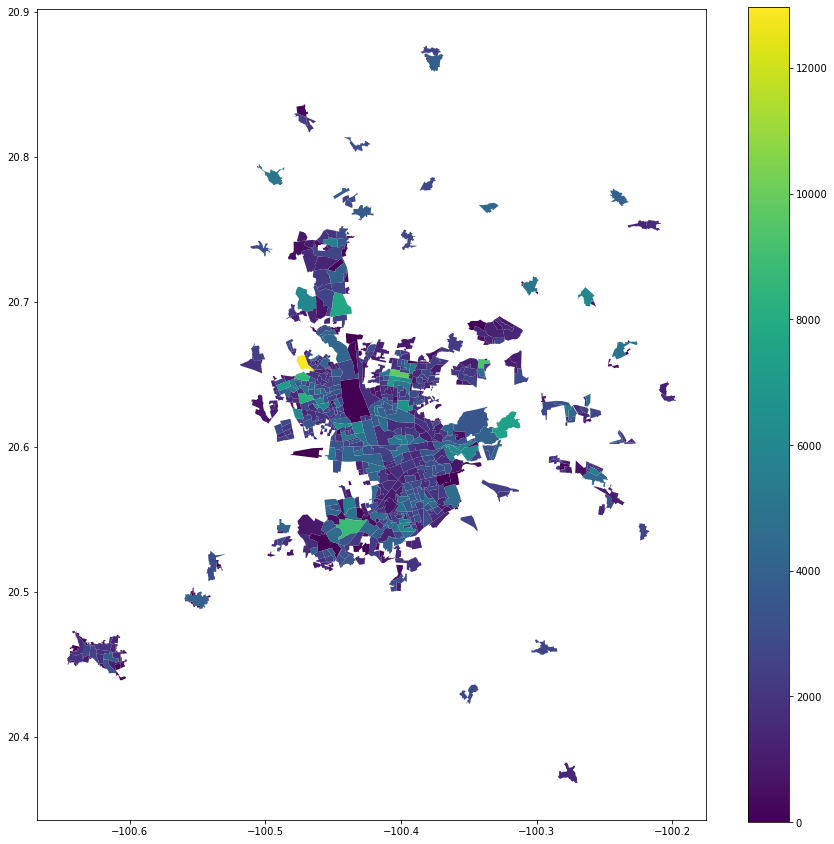

In [3]:
agebs.plot(column='POBTOT',figsize=(15, 15), legend=True)

In [4]:
agebs[agebs.columns[0:19]]

,NOM_MUN_x,clave,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,Ambito,ENTIDAD,NOM_ENT,MUN,NOM_MUN_y,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,POBMAS
0,Apaseo el Alto,11004,1100400010775,11,004,0001,0775,Urbana,11,Guanajuato,4,Apaseo el Alto,1,Total AGEB urbana,0775,0,3,*,*
1,Apaseo el Alto,11004,1100400010760,11,004,0001,0760,Urbana,11,Guanajuato,4,Apaseo el Alto,1,Total AGEB urbana,0760,0,0,0,0
2,Apaseo el Alto,11004,1100400010756,11,004,0001,0756,Urbana,11,Guanajuato,4,Apaseo el Alto,1,Total AGEB urbana,0756,0,27,15,12
3,Apaseo el Alto,11004,1100400650811,11,004,0065,0811,Urbana,11,Guanajuato,4,Apaseo el Alto,65,Total AGEB urbana,0811,0,3,*,*
4,Apaseo el Alto,11004,110040065078A,11,004,0065,078A,Urbana,11,Guanajuato,4,Apaseo el Alto,65,Total AGEB urbana,078A,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,Apaseo el Alto,11004,2201405075130,22,014,0507,5130,Urbana,22,Querétaro,14,Querétaro,507,Total AGEB urbana,5130,0,2541,1303,1238
662,Apaseo el Alto,11004,220140507508A,22,014,0507,508A,Urbana,22,Querétaro,14,Querétaro,507,Total AGEB urbana,508A,0,1097,533,564
663,Apaseo el Alto,11004,2201405075107,22,014,0507,5107,Urbana,22,Querétaro,14,Querétaro,507,Total AGEB urbana,5107,0,2187,1136,1051
664,Apaseo el Alto,11004,2201405075111,22,014,0507,5111,Urbana,22,Querétaro,14,Querétaro,507,Total AGEB urbana,5111,0,2039,1039,1000


In [30]:

## Obtenemos la matriz de adjacencia de los vecinos de los agebs
print("%-------------------------------------------------------------%")
print("Obtenemos la matriz de adjacencia de los vecinos de los agebs")
print("%--------------------------------------------------------------%")

adyacencia_dic = layer2net(agebs)


  0%|          | 0/5876 [00:00<?, ?it/s]

%-------------------------------------------------------------%
Obtenemos la matriz de adjacencia de los vecinos de los agebs
%--------------------------------------------------------------%


  4%|▍         | 240/5876 [02:41<1:03:06,  1.49it/s]


KeyboardInterrupt: 

In [ ]:
class Ageb:
    def __init__(self,cvegeo,poblacion,geometria,centroide,vivienda,alpha):
        self.cvegeo = cvegeo
        self.poblacion = {0 : poblacion}
        self.vivienda = {0 : vivienda}
        self.vecinos = []
        self.geometria  = geometria
        self.centroide = centroide
        self.distancia_vecino = {}
        self.ruta_vecino = {}
        self.crecimiento_natural = alpha
        self.distancia_trabajo = {'polanco':,
                                 'del_valle':}
        self.densidad = {0:  poblacion/vivienda}
        
    def actualiza_densidad(self,t):
        self.densidad[t] = self.poblacion[t]/self.vivienda[t] 
    
    def crec_natu(self,t):
        self.poblacion[t] = (1+self.alpha)*self.poblacion[t-1]

class Network:
    def __init__(self):
        self.agebs ={}


In [6]:

# Instancia de la clase Network()
agebs_net = Network()

# Agregamos las instancias de cada ageb en el diccionacio de agebs_net
print("%-------------------------------------------------------------%")
print("Agregamos las instancias de cada ageb en el diccionacio de agebs_net")
print("%--------------------------------------------------------------%")
for ageb in tqdm(list(adyacencia_dic.keys())):
    poblacion = agebs[agebs["CVEGEO"]==ageb]["POBTOT"].item()
    geometria = agebs[agebs["CVEGEO"]==ageb]["geometry"].item()
    centroide = agebs[agebs["CVEGEO"]==ageb]["centroide"].item()
    vivienda = agebs[agebs["CVEGEO"]==ageb]["VIVTOT"].item()
    agebs_net.agebs[ageb]=Ageb(ageb,poblacion,geometria,centroide, vivienda)

# Agregamos los vecinos de cada ageb
print("%-------------------------------------------------------------%")
print("Agregamos los vecinos de cada ageb")
print("%--------------------------------------------------------------%")
for ageb in tqdm(list(adyacencia_dic.keys())):
    lista_vecinos = list(np.where((adyacencia_dic[ageb]==1))[0])
    ref_vecinos = []

    if len(lista_vecinos)==0:
        pass
    else:
        for vecino in np.take(list(agebs_net.agebs.keys()),lista_vecinos):
            ref_vecinos.append(agebs_net.agebs[vecino])
        agebs_net.agebs[ageb].vecinos=ref_vecinos


  3%|▎         | 23/666 [00:00<00:02, 224.68it/s]

%-------------------------------------------------------------%
Agregamos las instancias de cada ageb en el diccionacio de agebs_net
%--------------------------------------------------------------%


100%|██████████| 666/666 [00:00<00:00, 8888.10it/s]

%-------------------------------------------------------------%
Agregamos los vecinos de cada ageb
%--------------------------------------------------------------%


In [11]:
agebs_net.agebs['220140001038A'].poblacion

{0: 1493}

In [12]:
## Pensemos que la población en este ageb crece en 2%
for t in range(10):
    agebs_net.agebs['220140001038A'].poblacion[t+1]= (1+0.02) * agebs_net.agebs['220140001038A'].poblacion[t]
    
agebs_net.agebs['220140001038A'].poblacion

{0: 1493,
 1: 1522.8600000000001,
 2: 1553.3172000000002,
 3: 1584.3835440000003,
 4: 1616.0712148800003,
 5: 1648.3926391776004,
 6: 1681.3604919611523,
 7: 1714.9877018003754,
 8: 1749.2874558363828,
 9: 1784.2732049531105,
 10: 1819.9586690521728}

In [13]:
for vecino in agebs_net.agebs['220140001038A'].vecinos:
    print("El ageb de 220140001038A con población {} tiene por vecino a la ageb {} con población {}".format(agebs_net.agebs['220140001038A'].poblacion[0],vecino.cvegeo,vecino.poblacion[0]))

El ageb de 220140001038A con población 1493 tiene por vecino a la ageb 2201400012314 con población 1744
El ageb de 220140001038A con población 1493 tiene por vecino a la ageb 2201400010303 con población 4773
El ageb de 220140001038A con población 1493 tiene por vecino a la ageb 2201400010318 con población 2136
El ageb de 220140001038A con población 1493 tiene por vecino a la ageb 2201400010322 con población 1665
El ageb de 220140001038A con población 1493 tiene por vecino a la ageb 2201400010394 con población 3514
El ageb de 220140001038A con población 1493 tiene por vecino a la ageb 2201400010375 con población 2006
El ageb de 220140001038A con población 1493 tiene por vecino a la ageb 2201400010411 con población 2167


In [14]:
rutas = gpd.read_file("rutas_ZM_de_Querétaro.geojson")


In [21]:
gdf_distancias_rutas = rutas.to_crs("EPSG:32614")

gdf_distancias_rutas['metros']=gdf_distancias_rutas['geometry'].length
gdf_distancias_rutas

,origen,destino,geometry,metros
0,1100400010775,1100400010455,None,NaN
1,1100400010775,1100400010309,"LINESTRING (329002.144 2264491.653, 329149.599...",1630.305660
2,1100400010775,1100400010370,"LINESTRING (329002.144 2264491.653, 329149.599...",3968.855501
3,1100400010760,1100400010455,None,NaN
4,1100400010756,110040001014A,"LINESTRING (332244.508 2264222.297, 332141.571...",912.496247
...,...,...,...,...
2799,2201405075107,220140507508A,"LINESTRING (358896.895 2284087.677, 359018.896...",2041.575688
2800,2201405075107,2201405075111,"LINESTRING (358896.895 2284087.677, 359018.896...",1162.553402
2801,2201405075111,2201405075130,"LINESTRING (359465.698 2284226.719, 359386.700...",889.408440
2802,2201405075111,220140507508A,"LINESTRING (359465.698 2284226.719, 359386.700...",1398.585529


In [26]:
for t in range(10):
    print(t)
    for ageb in agebs_net.agebs:
        agebs_net.agebs[ageb].poblacion[t+1] = (1+.002)*agebs_net.agebs[ageb].poblacion[t] 
    

0
1
2
3
4
5
6
7
8
9


In [27]:
agebs_net.agebs['1100400010737'].poblacion

{0: 8,
 1: 8.016,
 2: 8.032032,
 3: 8.048096064,
 4: 8.064192256127999,
 5: 8.080320640640256,
 6: 8.096481281921536,
 7: 8.11267424448538,
 8: 8.128899592974351,
 9: 8.1451573921603,
 10: 8.161447706944621}

<AxesSubplot:>

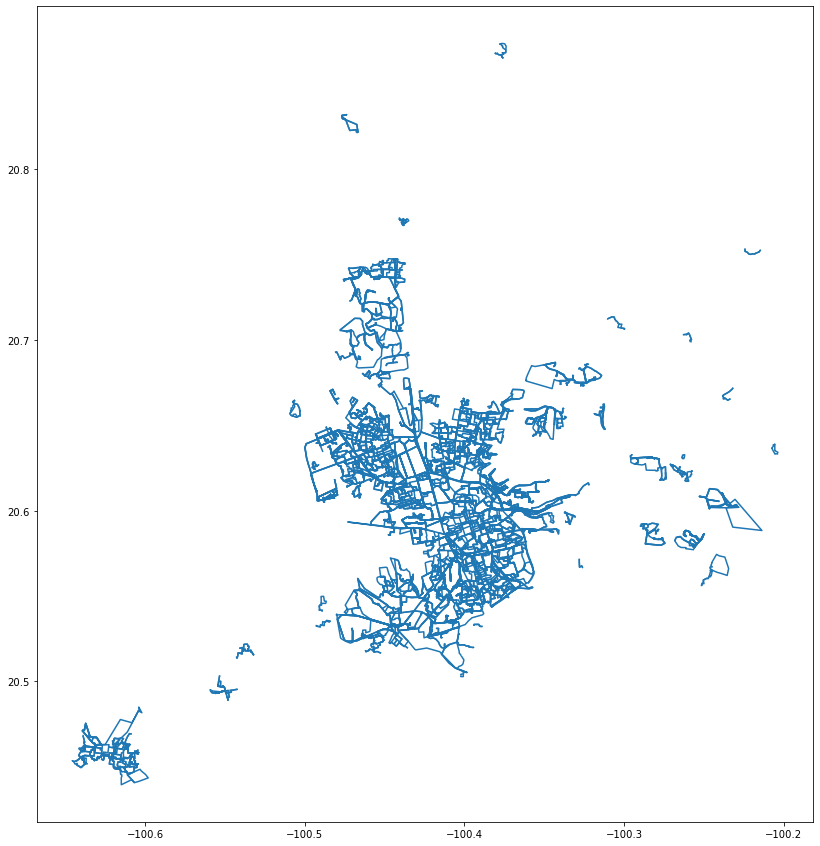

In [33]:
rutas.plot(figsize =(15,15))